# Classical Net (CNet) Unit Test on GHZ State
The goal of this notebook is to construct a first step in the classical component of the hybrid quantum net. Ultimately, the classical net (CNet) should be able to take the parametrization of the quantum circuit as input and output the desired loss metric to a high degree of accuracy. As a first round, instead of giving the parameters, we will give the actual probability distributions themselves and see if it can learn the metric from the distributions. This is generally an easier problem since the distbution gives maximal information.

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
from math import pi
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector

import torch as t
from torch.nn import functional as F
import torch.nn as nn

In [86]:
# Useful decimal to binary converter
def qubit_expansion(L):
    """Returns list of all L-qubits in z basis in lexicographical order"""
    assert isinstance(L, int) and L > 0
    d2b = np.vectorize(np.binary_repr)
    return d2b(np.arange(2**L), L)

## Construction of the State

In [87]:
STATE_TYPE = 'GHZ'
if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**3)
    qc = GHZ_state_circuit()
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(3) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(3).numpy()) # L = 3 qubits
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(3) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**9)
    qc = cluster_state_circuit(3)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")

           ┌───┐          
q182097_0: ┤ H ├──■────■──
           └───┘┌─┴─┐  │  
q182097_1: ─────┤ X ├──┼──
                └───┘┌─┴─┐
q182097_2: ──────────┤ X ├
                     └───┘


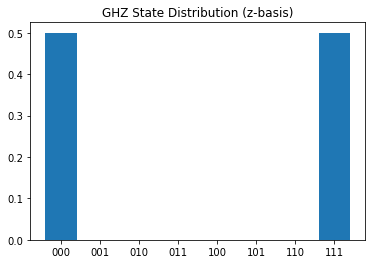

In [88]:
# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.title(f"{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## Loss Metric Choices

In [89]:
def KS(P1, P2):
    """Deprecated: KS Test on two discrete distributions"""
    assert len(P1) == len(P2)
    return np.abs(np.cumsum(P1) - np.cumsum(P2)).max()

In [90]:
def KL(P, Q, eps=1e-7):
    """KL divergence on two discrete distributions"""
    P = P + eps * np.ones_like(P)
    Q = Q + eps * np.ones_like(Q)
    return np.sum(P * np.log(P/Q))

def SymKL(P, Q, eps=1e-7):
    """Symmetrized KL divergence on two discrete distributions"""
    return 1/2 * (KL(P, Q, eps) + KL(Q, P, eps))

In [91]:
def Gaussian(x, m, s):
    """Element-wise Gaussian map with mean m and deviation s"""
    return np.exp(-np.square(x-m) / (2 * s**2))

def Em_MMD(x, y, s):
    """Empirical (sample) MMD loss function with width parameter s"""
    assert len(x) == len(y), f"Samples x and y differ in size: {len(x)} vs {len(y)}"
    n = len(x)
    return sum([Gaussian(x[i], x[j], s) + Gaussian(y[i], y[j], s) - \
           2*Gaussian(x[i], y[j], s) for i in range(n) for j in range(n)]) / n**2

def MMD(P, Q, n=101, s=1):
    """
    Define the MMD loss over distributions as a random variable obtained by sampling
    from the distributions and computing the empirical MMD over the samples.
    """
    return Em_MMD(npr.choice(len(P), size=n, p=P), \
                  npr.choice(len(Q), size=n, p=Q), s=s)

## Learning in Multiple Bases
By analogy to partial tomography, our quantum learning scheme requires multiple bases to learn the phases in the state expansion. The general idea will be to (a) randomly sample bases until a good one is found (i.e. one where the learning converges well) and then (b) perturb that basis slightly by a small rotation to generate a second good basis. It is possible to replace (b) with a second random sampling, but there is no need to do this unless we find that the above scheme doesn't learn the phases well enough because the two bases are too close to each other. Hopefully, that will not be the case.

In [92]:
"""
Given a quantum state expressed in the z-basis, we apply a quantum circuit
operation to change the basis into a different one, using a parametrizaed
rotation via 1-gates. 
Current metric: KL divergence.
"""
class BasisTransformer:
    def __init__(self, states, updated_parameters):
        self.states = states
        self.L = states[0].num_qubits
        assert np.all([states[0].num_qubits == state.num_qubits for state in states])
        if type(updated_parameters).__module__ == t.__name__:
            self.p = updated_parameters.clone().cpu().detach().numpy()
        else:
            assert type(updated_parameters).__module__ == np.__name__
            self.p = updated_parameters
        self.__transform()
    
    def __make_qc(self):
        """
        Make the quantum circuit in qiskit to execute the transformation. Rotation
        performed with qiskit U-gates: https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html
        
        param_mat: L x L matrix of (theta, phi, lambda) parameters (each col)
        """
        qubits = QuantumRegister(self.L)
        qc = QuantumCircuit(qubits)
        
        for i in range(self.L):
            qc.u(*self.p[i], qubits[i])
        self.qc = qc
    
    def __transform(self):
        """Perform the change of basis for each state"""
        self.__make_qc()
        self.transformed_states = [state.copy().evolve(self.qc) for state in self.states]
    
    def transformed_states(self):
        return self.transformed_states
    
    def updated_dist(self):
        return [state.probabilities() for state in self.transformed_states]

In [93]:
"""
For two bases, generate train and test datasets along with the true metric value.
Specify a basis parametrization in addition to the state itself (assumed ot be in z-basis).
Apply a theta-parametrized quantum circuit Q_theta (Q_th) to the state.
"""
TRAIN_SIZE = 3000
TEST_SIZE = 500
SAMPLING_DENSITY = 200
class CNetDataGenerator:
    def __init__(self, state, basis_param):
        self.metric = KL #* change this if the metric changes
        self.state = BasisTransformer([state], basis_param).transformed_states[0]
        self.L = state.num_qubits
        
    def __Q_th(self, p):
        """
        Apply the quantum circuit in qiskit corresponding to Q_theta with parameters p.
        For the moment, it is also just a bunch of single-qubit rotations.
        This will eventually change to a richer parametrization of circuits.
        """
        qubits = QuantumRegister(self.L)
        Q_th = QuantumCircuit(qubits)
        p_sqrt = int(np.sqrt(p.size()[0]))
        p = t.reshape(p, (p_sqrt, p_sqrt))
        if type(p).__module__ == t.__name__:
            p = p.clone().cpu().detach().numpy()
        
        for i in range(self.L):
            Q_th.u(*p[i], qubits[i])
        return self.state.copy().evolve(Q_th)
        
    def __true_loss(self, p):
        """
        Calculate the metric loss of Q_th(p)|state> against reference |state>,
        where p parametrizes the circuit Q_th.
        """
        return self.metric(self.state.probabilities(), self.__Q_th(p).probabilities())
    
    def __generate_some_data(self, sz):
        """
        Generate a random input parameter, which input to the CNet, 
        sampled from X ~ 2 * Pi * DUnif(n), whwere n = SAMPLING_DENSITY.
        """
        dataset = t.zeros(sz, 3*self.L + 1) # + 1 for the output value
        
        params = t.randint(0, SAMPLING_DENSITY, (sz, self.L*3)) * 2 * pi / SAMPLING_DENSITY
        dataset[:,:-1] = params
        
        true_metric = t.tensor([self.__true_loss(param) for param in params]) # target value for CNet
        dataset[:,-1] = true_metric
        return dataset
  
    def generate_train_test(self, train_size=TRAIN_SIZE, test_size=TEST_SIZE):
        """Generate the train and test datasets for neural network training"""
        train_data = self.__generate_some_data(train_size)
        test_data = self.__generate_some_data(test_size)
        return train_data, test_data

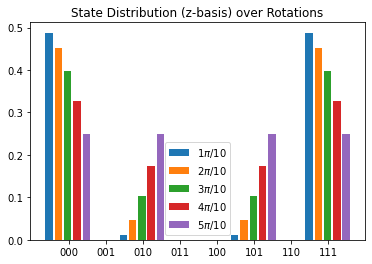

In [94]:
# Example: change of basis with 5 uniform Pi/10 rotations.
basis_p = t.zeros(3,3) # generally L x 3
fig, ax = plt.subplots()
for i in range(5):
    basis_p[1,0] += pi/10
    # print(f"[{i+1}/5] Parameter matrix:\n", parameter)
    dist_i = BasisTransformer([state], basis_p).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.175*state.num_qubits, dist_i, width=0.2)
    bar.set_label(rf"${i+1}\pi/10$")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.title("State Distribution (z-basis) over Rotations")
plt.show()

## Classical Deep Neural Net Construction
We will use Pyt for the neural net implementation.
Potential architectures:
1. Feed-forward: very simple, but possibly ineffective.
2. Convolutional: simple, respects 1-local structure of the qubit change-of-basis.
3. Variational autoencoder: used to project distributions, but no clear generalization to learn-by-parameters in place of learn-by-distribution.

In [95]:
"""
The CNet component of the HQ Net. 
In iteration 1: CNet is a stochastic function approximator
mapping distributions to the approximate metric.

Implementation followed from: https://pyt.org/tutorials/beginner/blitz/neural_networks_tutorial.html.

Currently, the metric we use is the: KL Divergence.
"""
def my_loss(x):
    return x * t.pow(t.sin(x), 2)

HIDDEN_DIM = 100
CONV_NCHAN = 4
class CNet(nn.Module):
    def __init__(self, num_qubits):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, CONV_NCHAN, (1,3))
        self.conv2 = nn.Conv2d(CONV_NCHAN, CONV_NCHAN, (1,1))
        self.linear1 = nn.Linear(12, HIDDEN_DIM)
        self.linear2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear3 = nn.Linear(HIDDEN_DIM, 1)
        self.model = self
        self.batch_size = 100
        self.loss_func = nn.MSELoss()
    
    def forward(self, param):
        x = param.view(-1, 3, 3)
        x = t.unsqueeze(x, 1)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(-1, 12)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        return x
    
    def train(self, train_data, nepoch=2000, eta=1e-3):
        """Train the net with learning rate `eta` for `nepochs` epochs"""
        true_metric = train_data[:,-1] # True metric value
        sz = train_data.size(0)
        self.optimizer = t.optim.Adam(self.model.parameters(), lr=eta)
        self.losses = np.zeros(nepoch // 10)
        
        for epoch in range(nepoch):
            self.optimizer.zero_grad()
            batch_idxs = random.sample(range(sz), self.batch_size)
            batch = train_data[batch_idxs].clone()
            estimated_metric = self.model(batch[:,:-1]).squeeze()
            loss = self.loss_func(estimated_metric, true_metric[batch_idxs])
            if epoch % 10 ==0:
                self.losses[epoch // 10] = loss.item()
            loss.backward()
            self.optimizer.step()
            if epoch % 1000 == 0:
                print("Finished Epoch:", epoch)
        return self.losses
    
    def test(self, test_data):
        """Apply the CNet to a test dataset. Returns the cross-validation MSE"""
        estimated_metric = self.model(test_data[:,:-1]).detach()
        true_metric = self.test_data[:,-1]
        return t.pow(estimated_metric - true_metric, 2).sum() / current.size(0)

## CNet Training on State
We generate the train and test input data, and train the CNet to learn the metric.

Finished Epoch: 0
Finished Epoch: 1000
Finished Epoch: 2000
Finished Epoch: 3000
[1/2] Final loss: 0.6882557140456306
Finished Epoch: 0
Finished Epoch: 1000
Finished Epoch: 2000
Finished Epoch: 3000
[2/2] Final loss: 0.4602942433622148


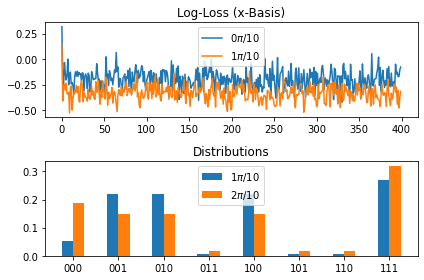

In [96]:
# Train one with a rotation of 0, one with Pi/10
X_BASIS = True
num_bases = 2
basis_p = t.zeros(state.num_qubits, 3) # z-basis
if X_BASIS:
    basis_p[:,0] = t.ones(3) * pi/2 # x-basis
fig, (ax1, ax2) = plt.subplots(nrows=2)
for i in range(num_bases):
    train_data, test_data = CNetDataGenerator(state, basis_p).generate_train_test()
    basis_p[:,0] += pi/10 * t.ones(3) # change the basis param for next iteration of loop
    net = CNet(state.num_qubits)
    losses = net.train(train_data, nepoch=4000, eta=1e-2)

    ax1.plot(np.arange(len(losses)), np.log10(losses), label=fr'{i}$\pi/10$')

    dist_i = BasisTransformer([state], basis_p).updated_dist()[0]
    bar = ax2.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.125, dist_i, width=0.25)
    bar.set_label(fr"${i+1}\pi/10$")
    print(f"[{i+1}/{num_bases}] Final loss: {np.mean(losses[-10:-1])}")
ax1.legend(); ax2.legend()
ax2.set_xticks(np.arange(2**state.num_qubits))
ax2.set_xticklabels(qubit_expansion(state.num_qubits))
ax1.set_title(f'Log-Loss ({"x" if X_BASIS else "z"}-Basis)'); ax2.set_title('Distributions')
fig.tight_layout()
plt.show()